#StockSense
![Online Image](https://img.freepik.com/free-vector/gradient-stock-market-concept_23-2149166910.jpg?w=740&t=st=1695490415~exp=1695491015~hmac=9287a125fd400a6a9aa681556bceff09bbc949443ad5bab3e4854b6f452beaf4)
In today's dynamic financial markets, making informed investment decisions is crucial for investors and traders. Predicting stock prices accurately is a challenging task that has garnered significant interest from researchers and financial professionals. Project WISENN (Web-based Interface for Stock Expectations using Neural Networks) aims to develop a user-friendly web application that leverages the power of neural networks to predict stock prices and provide valuable insights to users.

It fetches historical stock data for AAPL from Yahoo Finance, preprocesses it, creates a windowed dataset, and trains an LSTM-based neural network model for stock price prediction.

These code blocks together form a pipeline for fetching, preprocessing, and training a neural network model for stock price prediction, with visualizations at various stages to assess the model's performance.

##Data Retrieval and Preprocessing

* Fetches historical stock data for AAPL from Yahoo Finance.
* Converts the date column to datetime format.
* Selects the "Close" column.
* Imports necessary libraries and defines utility functions for date conversion.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import RandomOverSampler
from sklearn.metrics import classification_report

In [2]:
import yfinance as yf
import pandas as pd
import os

In [3]:
df = yf.Ticker("AAPL")
df = df.history(period="max")
df.to_csv("sp500.csv")

In [4]:
df

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
1980-12-12 00:00:00-05:00,0.099319,0.099750,0.099319,0.099319,469033600,0.0,0.0
1980-12-15 00:00:00-05:00,0.094569,0.094569,0.094137,0.094137,175884800,0.0,0.0
1980-12-16 00:00:00-05:00,0.087659,0.087659,0.087228,0.087228,105728000,0.0,0.0
1980-12-17 00:00:00-05:00,0.089387,0.089818,0.089387,0.089387,86441600,0.0,0.0
1980-12-18 00:00:00-05:00,0.091978,0.092410,0.091978,0.091978,73449600,0.0,0.0
...,...,...,...,...,...,...,...
2023-11-27 00:00:00-05:00,189.919998,190.669998,188.899994,189.789993,40552600,0.0,0.0
2023-11-28 00:00:00-05:00,189.779999,191.080002,189.399994,190.399994,38415400,0.0,0.0
2023-11-29 00:00:00-05:00,190.899994,192.089996,188.970001,189.369995,43014200,0.0,0.0


In [5]:
df = df[["Close"]]

In [6]:
import datetime

def str_to_datetime(s):
  split = s.split('-')
  year, month, day = int(split[0]), int(split[1]), int(split[2])
  return datetime.datetime(year=year, month=month, day=day)

df['Date'] = df['Date'].apply(str_to_datetime)
df['Date']

KeyError: ignored

##Windowed Dataset Creation

* Creates a windowed dataset for training the neural network.
* Iterates through the historical data, creating overlapping windows of stock prices.
* Calculates input features (X) and target values (Y) for the model.

In [7]:
import numpy as np

def df_to_windowed_df(dataframe, first_date_str, last_date_str, n=3):
  first_date = str_to_datetime(first_date_str)
  last_date  = str_to_datetime(last_date_str)

  target_date = first_date

  dates = []
  X, Y = [], []

  last_time = False
  while True:
    df_subset = dataframe.loc[:target_date].tail(n+1)

    if len(df_subset) != n+1:
      print(f'Error: Window of size {n} is too large for date {target_date}')
      return

    values = df_subset['Close'].to_numpy()
    x, y = values[:-1], values[-1]

    dates.append(target_date)
    X.append(x)
    Y.append(y)

    next_week = dataframe.loc[target_date:target_date+datetime.timedelta(days=7)]
    next_datetime_str = str(next_week.head(2).tail(1).index.values[0])
    next_date_str = next_datetime_str.split('T')[0]
    year_month_day = next_date_str.split('-')
    year, month, day = year_month_day
    next_date = datetime.datetime(day=int(day), month=int(month), year=int(year))

    if last_time:
      break

    target_date = next_date

    if target_date == last_date:
      last_time = True

  ret_df = pd.DataFrame({})
  ret_df['Target Date'] = dates

  X = np.array(X)
  for i in range(0, n):
    X[:, i]
    ret_df[f'Target-{n-i}'] = X[:, i]

  ret_df['Target'] = Y

  return ret_df

# Start day second time around: '2021-03-25'
windowed_df = df_to_windowed_df(df,
                                '2021-03-25',
                                '2022-03-23',
                                n=3)
windowed_df

<ipython-input-7-afb704e9f7b7>:14: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  df_subset = dataframe.loc[:target_date].tail(n+1)
<ipython-input-7-afb704e9f7b7>:27: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  next_week = dataframe.loc[target_date:target_date+datetime.timedelta(days=7)]


,Target Date,Target-3,Target-2,Target-1,Target
0,2021-03-25,121.429810,120.593330,118.182228,118.674294
1,2021-03-26,120.593330,118.182228,118.674294,119.284439
2,2021-03-29,118.182228,118.674294,119.284439,119.461586
3,2021-03-30,118.674294,119.284439,119.461586,117.995262
4,2021-03-31,119.284439,119.461586,117.995262,120.209511
...,...,...,...,...,...
247,2022-03-17,149.108215,153.533371,157.988190,159.007843
248,2022-03-18,153.533371,157.988190,159.007843,162.334137
249,2022-03-21,157.988190,159.007843,162.334137,163.720078
250,2022-03-22,159.007843,162.334137,163.720078,167.125549


##Data Transformation

Converts the windowed dataset into suitable formats for training (dates, input features X, and target values Y).

In [8]:
def windowed_df_to_date_X_y(windowed_dataframe):
  df_as_np = windowed_dataframe.to_numpy()

  dates = df_as_np[:, 0]

  middle_matrix = df_as_np[:, 1:-1]
  X = middle_matrix.reshape((len(dates), middle_matrix.shape[1], 1))

  Y = df_as_np[:, -1]

  return dates, X.astype(np.float32), Y.astype(np.float32)

dates, X, y = windowed_df_to_date_X_y(windowed_df)

dates.shape, X.shape, y.shape

((252,), (252, 3, 1), (252,))

##Data Splitting and Visualization

Splits the dataset into training, validation, and testing sets based on date ranges.

Plots the stock prices for training, validation, and testing datasets.

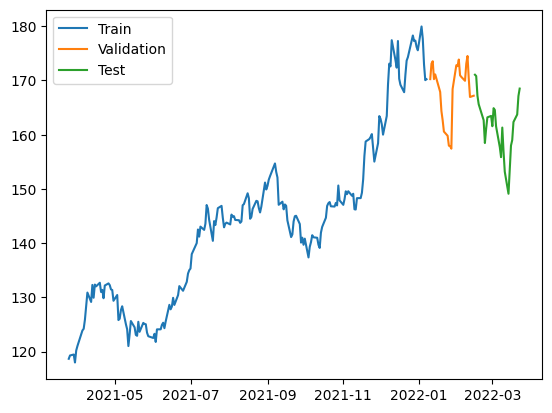

In [9]:
q_80 = int(len(dates) * .8)
q_90 = int(len(dates) * .9)

dates_train, X_train, y_train = dates[:q_80], X[:q_80], y[:q_80]

dates_val, X_val, y_val = dates[q_80:q_90], X[q_80:q_90], y[q_80:q_90]
dates_test, X_test, y_test = dates[q_90:], X[q_90:], y[q_90:]

plt.plot(dates_train, y_train)
plt.plot(dates_val, y_val)
plt.plot(dates_test, y_test)

plt.legend(['Train', 'Validation', 'Test'])

In [10]:
yt = (y_test > 0.5).astype(int).reshape(-1,)

##Model Building

Defines a Sequential neural network model with LSTM and dense layers.
Compiles the model with Mean Squared Error (MSE) loss and Adam optimizer.

Model Training:

Trains the model using the training and validation datasets.

In [11]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import layers

model = Sequential([layers.Input((3, 1)),
                    layers.LSTM(64),
                    layers.Dense(32, activation='relu'),
                    layers.Dense(32, activation='relu'),
                    layers.Dense(1)])

model.compile(loss='mse',
              optimizer=Adam(learning_rate=0.001),
              metrics=['mean_absolute_error'])

model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=100)

Epoch 1/100
7/7 [==============================] - 3s 102ms/step - loss: 20790.2070 - mean_absolute_error: 143.3920 - val_loss: 28205.2383 - val_mean_absolute_error: 167.8572
Epoch 2/100
7/7 [==============================] - 0s 9ms/step - loss: 20716.9941 - mean_absolute_error: 143.1351 - val_loss: 28144.1152 - val_mean_absolute_error: 167.6750
Epoch 3/100
7/7 [==============================] - 0s 9ms/step - loss: 20665.7012 - mean_absolute_error: 142.9556 - val_loss: 28075.7949 - val_mean_absolute_error: 167.4712
Epoch 4/100
7/7 [==============================] - 0s 12ms/step - loss: 20597.4160 - mean_absolute_error: 142.7180 - val_loss: 27971.1484 - val_mean_absolute_error: 167.1585
Epoch 5/100
7/7 [==============================] - 0s 9ms/step - loss: 20492.2070 - mean_absolute_error: 142.3479 - val_loss: 27817.7832 - val_mean_absolute_error: 166.6991
Epoch 6/100
7/7 [==============================] - 0s 9ms/step - loss: 20340.9785 - mean_absolute_error: 141.8125 - val_loss: 27594.

##Training Predictions Visualization

Plots the model's predictions and actual stock prices for the training dataset

7/7 [==============================] - 0s 3ms/step


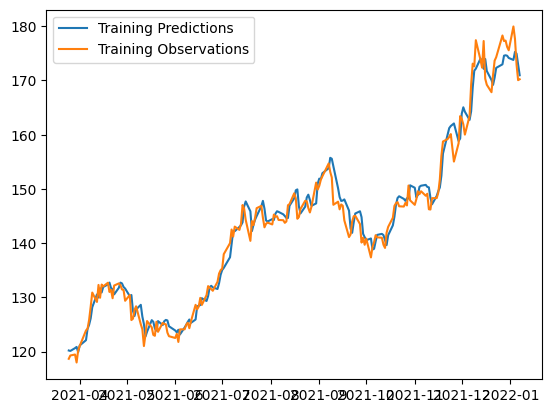

In [12]:
train_predictions = model.predict(X_train).flatten()

plt.plot(dates_train, train_predictions)
plt.plot(dates_train, y_train)
plt.legend(['Training Predictions', 'Training Observations'])

##Validation Predictions Visualization

Plots the model's predictions and actual stock prices for the validation dataset.

1/1 [==============================] - 0s 20ms/step


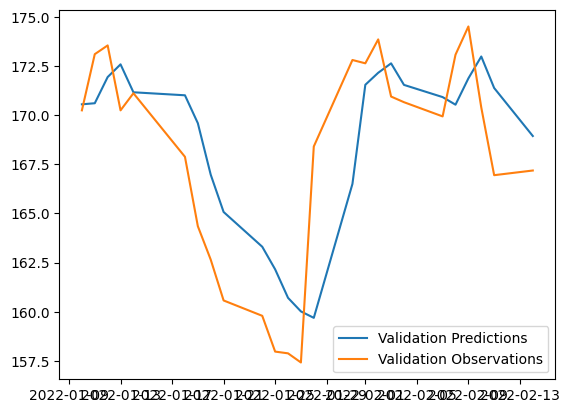

In [13]:
val_predictions = model.predict(X_val).flatten()

plt.plot(dates_val, val_predictions)
plt.plot(dates_val, y_val)
plt.legend(['Validation Predictions', 'Validation Observations'])

##Testing Predictions Visualization

Plots the model's predictions and actual stock prices for the testing dataset.

1/1 [==============================] - 0s 22ms/step


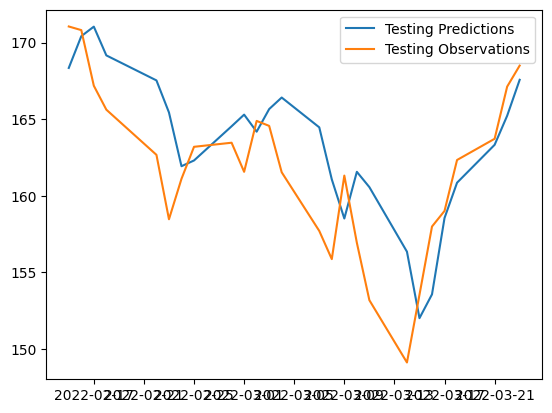

In [14]:
test_predictions = model.predict(X_test).flatten()

plt.plot(dates_test, test_predictions)
plt.plot(dates_test, y_test)
plt.legend(['Testing Predictions', 'Testing Observations'])